<a href="https://colab.research.google.com/github/mridul-gupta-ds/Data-Science/blob/master/hotel_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [2]:
df_raw = pd.read_csv("/content/tripadvisor_hotel_reviews.csv")

In [3]:
df = df_raw.copy()

In [4]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
# Drop NULL comments
df.drop(df[df['Review'].isnull()].index,inplace=True)

In [6]:
!pip install spacy_langdetect
!pip install googletrans

In [7]:

import spacy
from spacy_langdetect import LanguageDetector
nlp = spacy.load('en')
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
text = 'Nous sommes une équipe'

def language_detector(text):
  doc = nlp(text)
  # document level language detection. Think of it like average language of the document!
  return doc._.language['language']

language_detector(text)

'fr'

In [10]:
from googletrans import Translator
translator=Translator()
def translate_from_french(response,lang):
    print(response)
    if lang == 'fr':
      return translator.translate(response).text
    else:
      return response

translate_from_french(text,'fr')

Nous sommes une équipe


'We are a team'

In [11]:
def deEmojify(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

In [12]:
df['Responses_demoji'] = df.apply(lambda row: deEmojify(row['Review']), axis=1)

In [13]:
def get_label(rating):
  if rating==5:
    return 1
  elif rating==1 or rating==2:
    return 0
  else:
    return 2

In [14]:
df['label'] = df.apply(lambda row: get_label(row['Rating']),axis=1)

In [15]:
df.head()

,Review,Rating,Responses_demoji,label
0,nice hotel expensive parking got good deal sta...,4,nice hotel expensive parking got good deal sta...,2
1,ok nothing special charge diamond member hilto...,2,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4* experience hotel monaco seat...,3,nice rooms not 4* experience hotel monaco seat...,2
3,"unique, great stay, wonderful time hotel monac...",5,"unique, great stay, wonderful time hotel monac...",1
4,"great stay great stay, went seahawk game aweso...",5,"great stay great stay, went seahawk game aweso...",1


In [16]:
filterdf = df[df['label']==1]

In [17]:
data = filterdf.Responses_demoji.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['unique, great stay, wonderful time hotel monaco, location excellent short '
 'stroll main downtown shopping area, pet friendly room showed no signs animal '
 'hair smells, monaco suite sleeping area big striped curtains pulled closed '
 'nice touch felt cosy, goldfish named brandi enjoyed, did nt partake free '
 'wine coffee/tea service lobby thought great feature, great staff friendly, '
 'free wireless internet hotel worked suite 2 laptops, decor lovely eclectic '
 'mix pattens color palatte, animal print bathrobes feel like rock stars, nice '
 'did nt look like sterile chain hotel hotel personality excellent stay, ']


In [18]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

In [19]:
## Bigram Example

from gensim.models import Phrases
documents_ex = ["this is the team meeting of rattle box", "rattle box","every one in rattle box team is present"]

sentence_stream_ex = [doc.split(" ") for doc in documents_ex]
bigram_ex = Phrases(sentence_stream_ex, min_count=1, threshold=2) ## (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold 
# higher threshold fewer phrases.
sent_ex = ['this', 'is', 'the', 'team', 'meeting', 'of', 'rattle','box','every','one','in','present']
print(bigram_ex[sent_ex])



['this', 'is', 'the', 'team', 'meeting', 'of', 'rattle_box', 'every', 'one', 'in', 'present']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [20]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)


In [21]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [22]:
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['room','good','hotel','resort','great','stay','excellent'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['unique', 'wonderful', 'time', 'location', 'short', 'stroll', 'main', 'downtown', 'shopping', 'area', 'friendly', 'show', 'sign', 'animal', 'hair', 'smell', 'area', 'big', 'stripe', 'curtain', 'pull', 'closed', 'nice', 'touch', 'feel', 'cosy', 'goldfish', 'name', 'enjoy', 'partake', 'free', 'wine', 'coffee', 'tea', 'service', 'lobby', 'think', 'feature', 'staff', 'friendly', 'free', 'work', 'laptop', 'lovely', 'eclectic', 'mix', 'patten', 'color', 'animal', 'print', 'bathrobe', 'feel', 'rock', 'star', 'nice', 'look', 'sterile', 'chain', 'personality']]


In [24]:
data_words_bigrams

[['unique',
  'wonderful',
  'time',
  'monaco',
  'location',
  'short',
  'stroll',
  'main',
  'downtown',
  'shopping',
  'area',
  'pet',
  'friendly',
  'showed',
  'signs',
  'animal',
  'hair',
  'smells',
  'monaco',
  'suite',
  'sleeping',
  'area',
  'big',
  'striped',
  'curtains',
  'pulled',
  'closed',
  'nice',
  'touch',
  'felt',
  'cosy',
  'goldfish',
  'named',
  'brandi',
  'enjoyed',
  'nt',
  'partake',
  'free',
  'wine',
  'coffee',
  'tea',
  'service',
  'lobby',
  'thought',
  'feature',
  'staff',
  'friendly',
  'free',
  'wireless_internet',
  'worked',
  'suite',
  'laptops',
  'decor',
  'lovely',
  'eclectic',
  'mix',
  'pattens',
  'color',
  'palatte',
  'animal',
  'print',
  'bathrobes',
  'feel',
  'like',
  'rock',
  'stars',
  'nice',
  'nt',
  'look',
  'like',
  'sterile',
  'chain',
  'personality'],
 ['went',
  'seahawk',
  'game',
  'awesome',
  'downfall',
  'view',
  'building',
  'nt',
  'complain',
  'huge',
  'staff',
  'helpful',


In [25]:
data_lemmatized = remove_stopwords(data_lemmatized)

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]]


In [27]:
# Readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('animal', 2),
  ('area', 2),
  ('bathrobe', 1),
  ('big', 1),
  ('chain', 1),
  ('closed', 1),
  ('coffee', 1),
  ('color', 1),
  ('cosy', 1),
  ('curtain', 1),
  ('downtown', 1),
  ('eclectic', 1),
  ('enjoy', 1),
  ('feature', 1),
  ('feel', 2),
  ('free', 2),
  ('friendly', 2),
  ('goldfish', 1),
  ('hair', 1),
  ('laptop', 1),
  ('lobby', 1),
  ('location', 1),
  ('look', 1),
  ('lovely', 1),
  ('main', 1),
  ('mix', 1),
  ('name', 1),
  ('nice', 2),
  ('partake', 1),
  ('patten', 1),
  ('personality', 1),
  ('print', 1),
  ('pull', 1),
  ('rock', 1),
  ('service', 1),
  ('shopping', 1),
  ('short', 1),
  ('show', 1),
  ('sign', 1),
  ('smell', 1),
  ('staff', 1),
  ('star', 1),
  ('sterile', 1),
  ('stripe', 1),
  ('stroll', 1),
  ('tea', 1),
  ('think', 1),
  ('time', 1),
  ('touch', 1),
  ('unique', 1),
  ('wine', 1),
  ('wonderful', 1),
  ('work', 1)]]

#LDA

In [27]:
import os       
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     
  !java -version       
install_java()

openjdk version "11.0.9.1" 2020-11-04
OpenJDK Runtime Environment (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04)
OpenJDK 64-Bit Server VM (build 11.0.9.1+1-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)


In [28]:
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [29]:
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' 

In [30]:
from gensim.models.wrappers import LdaMallet

In [31]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [32]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('restaurant', 0.03827571845064556),
   ('day', 0.025801749271137025),
   ('enjoy', 0.02040816326530612),
   ('evening', 0.01793002915451895),
   ('tour', 0.016638900458142442),
   ('relax', 0.013973344439816742),
   ('local', 0.013890045814244065),
   ('beautiful', 0.013452728029987504),
   ('place', 0.013286130778842149),
   ('dinner', 0.012723865056226573)]),
 (1,
  [('check', 0.04367594378616699),
   ('book', 0.03105932370192497),
   ('arrive', 0.027732944927764437),
   ('desk', 0.02200527496752352),
   ('give', 0.02106050466480337),
   ('morning', 0.019387473920403103),
   ('night', 0.018226193756642917),
   ('leave', 0.01799000118096288),
   ('day', 0.01741920245640279),
   ('early', 0.016218556863362595)]),
 (2,
  [('service', 0.07250093146601792),
   ('staff', 0.06038091480921384),
   ('experience', 0.03603129725820238),
   ('feel', 0.022574352905078133),
   ('make', 0.0224866855151555),
   ('visit', 0.020404585004492954),
   ('return', 0.01827865079886909),
   ('wife',

In [33]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [34]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=4, limit=10, step=2)

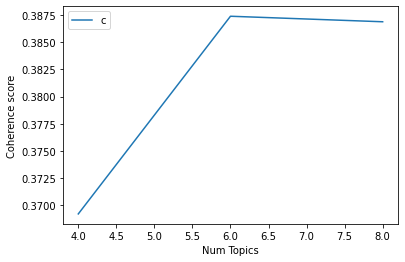

In [35]:
import matplotlib.pyplot as plt

# Show graph
limit=10; start=4; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [36]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.3692
Num Topics = 6  has Coherence Value of 0.3874
Num Topics = 8  has Coherence Value of 0.3869


In [37]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

[(0,
  '0.030*"restaurant" + 0.024*"day" + 0.022*"bar" + 0.021*"pool" + '
  '0.018*"night" + 0.012*"dinner" + 0.010*"area" + 0.009*"eat" + 0.009*"kid" + '
  '0.008*"food" + 0.008*"towel" + 0.007*"plenty" + 0.007*"morning" + '
  '0.007*"sit" + 0.007*"evening" + 0.007*"meal" + 0.007*"drink" + '
  '0.007*"enjoy" + 0.007*"open" + 0.007*"hot" + 0.007*"club" + 0.006*"main" + '
  '0.006*"lobby" + 0.006*"check" + 0.006*"lounge" + 0.006*"serve" + '
  '0.006*"lunch" + 0.006*"leave" + 0.006*"early" + 0.006*"table"'),
 (1,
  '0.048*"service" + 0.025*"staff" + 0.022*"feel" + 0.022*"experience" + '
  '0.018*"return" + 0.018*"wonderful" + 0.016*"make" + 0.014*"time" + '
  '0.012*"year" + 0.012*"trip" + 0.011*"family" + 0.011*"travel" + '
  '0.010*"wife" + 0.010*"visit" + 0.010*"home" + 0.009*"special" + '
  '0.008*"beautiful" + 0.008*"friend" + 0.007*"guest" + 0.007*"enjoy" + '
  '0.007*"arrive" + 0.007*"husband" + 0.007*"treat" + 0.007*"property" + '
  '0.006*"arrival" + 0.006*"star" + 0.006*"plan" 

#Finding the dominant topic in each sentence


In [38]:
def format_topics_sentences(ldamodel, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.2065,"bed, bathroom, small, breakfast, nice, large, ...","unique, great stay, wonderful time hotel monac..."
1,1,4.0,0.2466,"walk, view, minute, book, check, price, night,...","great stay great stay, went seahawk game aweso..."
2,2,5.0,0.2264,"bed, bathroom, small, breakfast, nice, large, ...",love monaco staff husband stayed hotel crazy w...
3,3,5.0,0.2599,"bed, bathroom, small, breakfast, nice, large, ...","cozy stay rainy city, husband spent 7 nights m..."
4,4,5.0,0.2312,"bed, bathroom, small, breakfast, nice, large, ...","hotel stayed hotel monaco cruise, rooms genero..."
5,5,3.0,0.1929,"staff, location, clean, friendly, helpful, bre...",excellent stayed hotel monaco past w/e delight...
6,6,4.0,0.2443,"walk, view, minute, book, check, price, night,...",fantastic stay monaco seattle hotel monaco hol...
7,7,3.0,0.2465,"staff, location, clean, friendly, helpful, bre...","good choice hotel recommended sister, great lo..."
8,8,4.0,0.2943,"walk, view, minute, book, check, price, night,...",service service service spent week g-friend la...
9,9,3.0,0.2166,"staff, location, clean, friendly, helpful, bre...","excellent stay, delightful surprise stay monac..."


In [39]:
df_dominant_topic.to_csv("main_positive_dominant_topic.csv")

#Find the most representative document for each topic

In [40]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4795,"restaurant, day, bar, pool, night, dinner, are...","true paradise, wife just returned wonderful re..."
1,1.0,0.4617,"service, staff, feel, experience, return, wond...",dream come true wedding married villa montana ...
2,2.0,0.7254,"time, people, food, beach, beautiful, lot, thi...","ca nt wait till year, 2nd 16th 2008we stayed l..."
3,3.0,0.3559,"staff, location, clean, friendly, helpful, bre...",loved just spent week seven bridges nov 28 dec...
4,4.0,0.4278,"walk, view, minute, book, check, price, night,...",unbelievably helpful staff reasons went barcel...


In [41]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4795,"restaurant, day, bar, pool, night, dinner, are...","true paradise, wife just returned wonderful re..."
1,1.0,0.4617,"service, staff, feel, experience, return, wond...",dream come true wedding married villa montana ...
2,2.0,0.7254,"time, people, food, beach, beautiful, lot, thi...","ca nt wait till year, 2nd 16th 2008we stayed l..."
3,3.0,0.3559,"staff, location, clean, friendly, helpful, bre...",loved just spent week seven bridges nov 28 dec...
4,4.0,0.4278,"walk, view, minute, book, check, price, night,...",unbelievably helpful staff reasons went barcel...
5,5.0,0.4326,"bed, bathroom, small, breakfast, nice, large, ...","charming hotel historic neighborhood, blue moo..."


In [42]:
sent_topics_sorteddf_mallet.to_csv("main_positive_most_representative_document_for_topic.csv")

#Topic distribution across documents

In [43]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,5.0,"bed, bathroom, small, breakfast, nice, large, ...",803.0,0.0887
1.0,4.0,"walk, view, minute, book, check, price, night,...",1470.0,0.1624
2.0,5.0,"bed, bathroom, small, breakfast, nice, large, ...",1283.0,0.1417
3.0,5.0,"bed, bathroom, small, breakfast, nice, large, ...",2194.0,0.2423
4.0,5.0,"bed, bathroom, small, breakfast, nice, large, ...",1514.0,0.1672
...,...,...,...,...
9049.0,3.0,"staff, location, clean, friendly, helpful, bre...",NaN,NaN
9050.0,5.0,"bed, bathroom, small, breakfast, nice, large, ...",NaN,NaN
9051.0,3.0,"staff, location, clean, friendly, helpful, bre...",NaN,NaN
9052.0,4.0,"walk, view, minute, book, check, price, night,...",NaN,NaN


In [44]:
df_dominant_topics.to_csv("main_positive_topic_distribution_in_documents.csv")

#Word Cloud

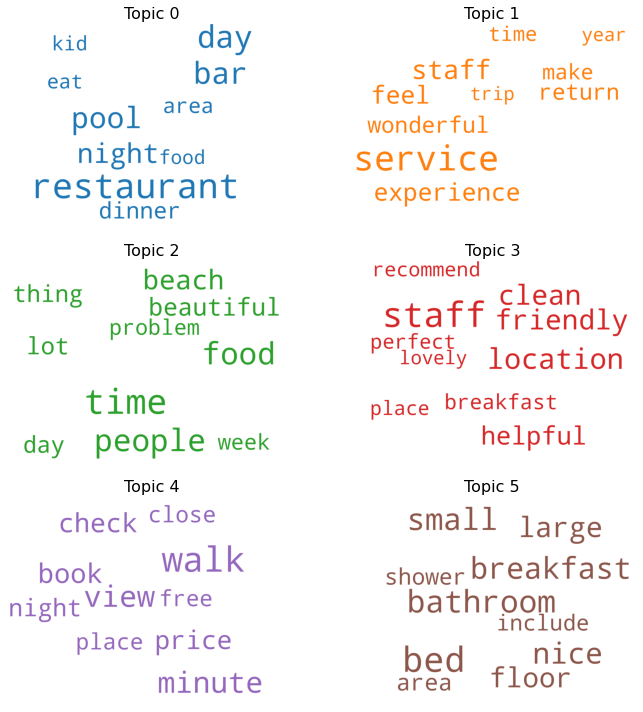

In [45]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#Word Counts of Topic Keywords

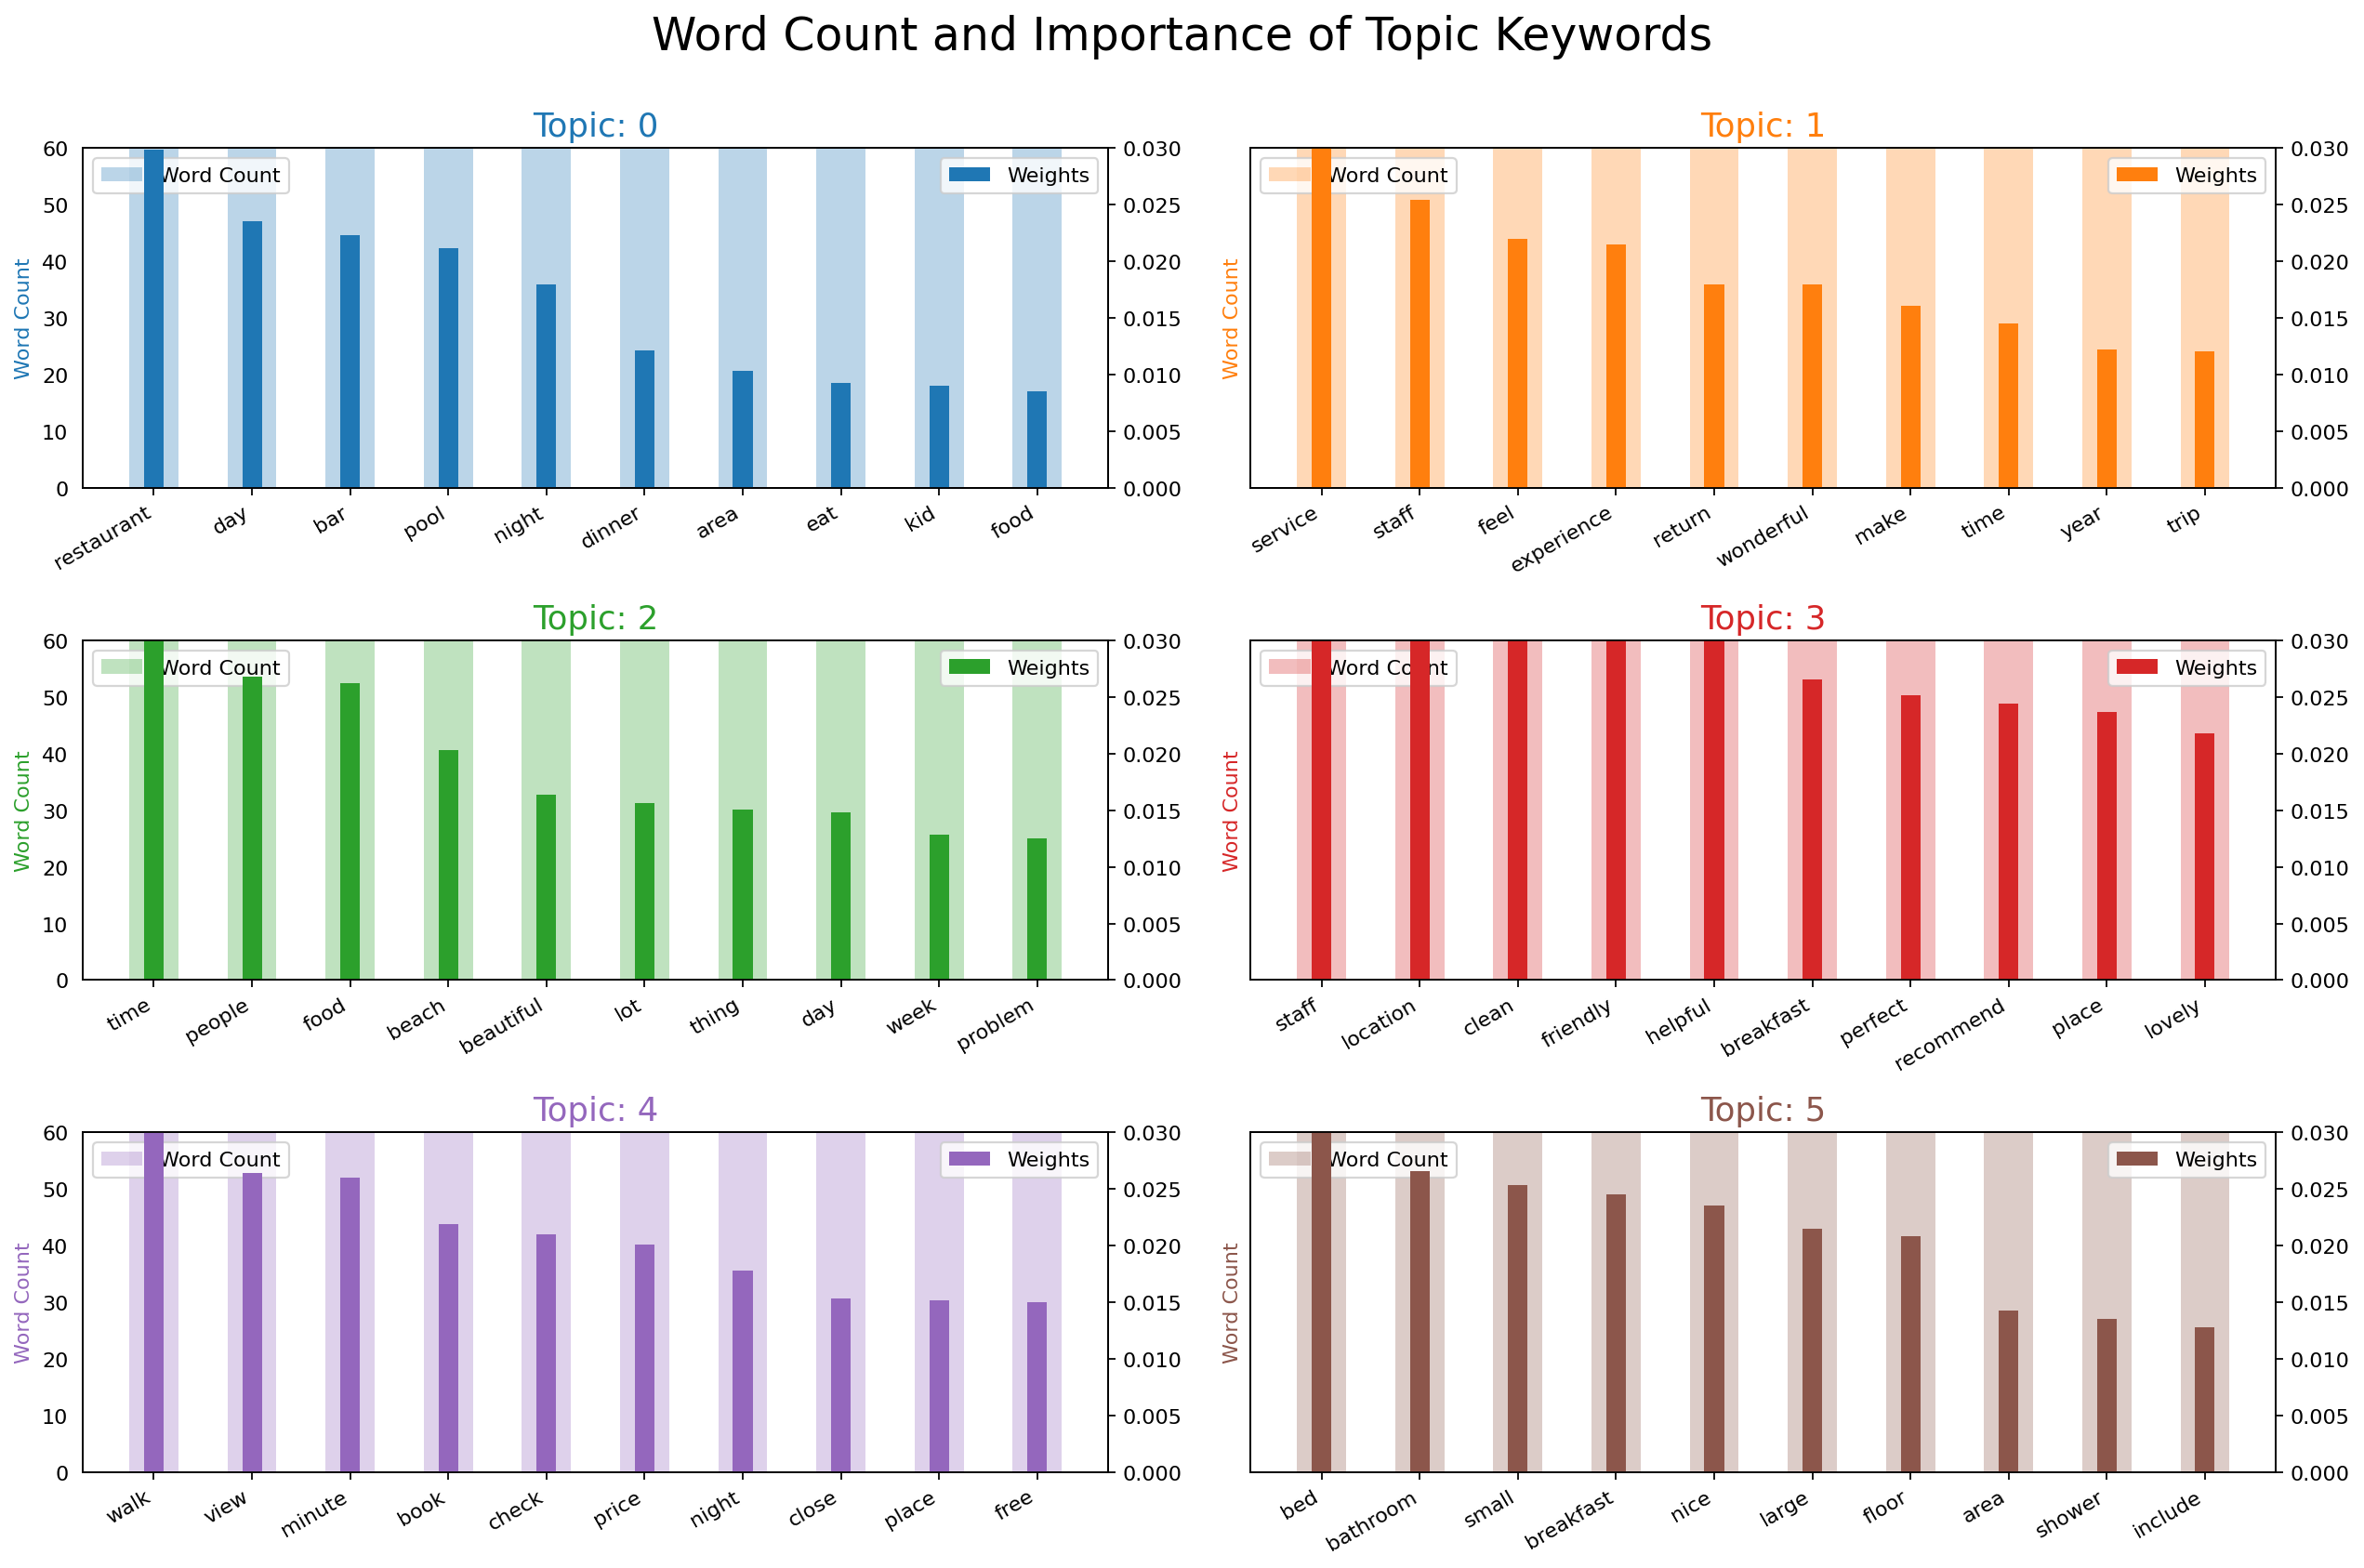

In [50]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 60)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

#PyLDA Vis


In [47]:
!pip install pyLDAvis

In [48]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [49]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model , corpus, dictionary=model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.000070 -0.000561       1        1  19.742410
0      0.000576  0.000137       2        1  18.508989
4     -0.000136  0.000923       3        1  16.103105
5     -0.000761 -0.000583       4        1  15.965091
1      0.000745 -0.000255       5        1  15.835211
3     -0.000494  0.000340       6        1  13.845194, topic_info=                 Term       Freq      Total Category  logprob  loglift
13165       induction  32.000000  32.000000  Default  30.0000  30.0000
1668            grade  30.000000  30.000000  Default  29.0000  29.0000
4167        criterion  29.000000  29.000000  Default  28.0000  28.0000
5295        spreadout  30.000000  30.000000  Default  27.0000  27.0000
4337        sensitive  28.000000  28.000000  Default  26.0000  26.0000
...               ...        ...        ...      ...      ...      ...
1476            urban   5.330597  32.002783   Topic6  -9.5778   0.1849
1239        character   5.313646  31.931585   Topic6  -9.5810   0.1839
12619  ramblaviewroom   5.234737  30.832593   Topic6  -9.5959   0.2040
2966       mysterious   5.258500  32.323154   Topic6  -9.5914   0.1613
6868             kite   5.259439  32.760824   Topic6  -9.5912   0.1480

[324 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
8751      1  0.185358  academia
8751      2  0.185358  academia
8751      3  0.154465  academia
8751      4  0.185358  academia
8751      5  0.154465  academia
...     ...       ...       ...
6777      2  0.156915       yet
6777      3  0.188298       yet
6777      4  0.156915       yet
6777      5  0.125532       yet
6777      6  0.156915       yet

[1848 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 6, 2, 4])